In [1]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
import torchvision
from torchvision import transforms
import numpy as np
from tqdm import tqdm
from syndata import get_exo_locations
import pandas as pd
from get_syndata import *

In [17]:
class SyntheticDataset(Dataset):
    
    def __init__(self,star:list,exo:list,transform=True,labelled=True):
            
        self.star      = star
        self.exo       = exo
        self.transform = transform 
        
        if labelled:
        
            self.arr      = np.concatenate((exo[0],star[0]))
            self.label    = torch.vstack((exo[1],star[1]))
        
            self.data = [self.arr,self.label]
            
        else:
            self.data      = np.concatenate((exo[0],star[0]))
            
        
    def __len__(self):
        
        return len(self.arr)
    
    def __getitem__(self,idx):
        
        sample = self.data[0][idx]
        
        if self.transform:
            sample = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.CenterCrop(160),
                   ])(sample)
        
        if labelled:
            
            label  = self.data[1][idx]
            return [sample,label]
        
        else:
            
            return sample
        

In [3]:
train_star, train_exo, test_star, test_exo = get_train_test()

Exo data: (12300, 320, 320)
Star data: (8064, 320, 320)


In [4]:
train_star_labelled, train_exo_labelled, test_star_labelled, test_exo_labelled = get_labelled_data(train_star, train_exo, test_star, test_exo)

In [18]:
train_dataset = SyntheticDataset(star=train_star_labelled,exo=train_exo_labelled,labelled=True)
test_dataset = SyntheticDataset(star=test_star_labelled,exo=test_exo_labelled,labelled=True)

In [12]:
train_dataloader = DataLoader(train_dataset,batch_size=512,shuffle=True)
test_dataloader = DataLoader(test_dataset,batch_size=512,shuffle=True)

In [19]:
_,train_samples = next(enumerate(train_dataloader))
_,test_sample = next(enumerate(test_dataloader))

In [20]:
# Visualize

In [21]:
#new_locs = [] 
#for x,y in exo_locs:
#    x_new, y_new = x-80,y-80
#    new_locs.append((x_new,y_new))

In [22]:
train_stack = torch.concat((train_samples[0][0],train_samples[0][1]))
test_stack  = torch.concat((test_sample[0][0],test_sample[0][1]))
for i in range(2,25):
    
    train_stack = torch.concat((train_stack,train_samples[0][i]),axis=0)
    test_stack = torch.concat((test_stack,test_sample[0][i]),axis=0)


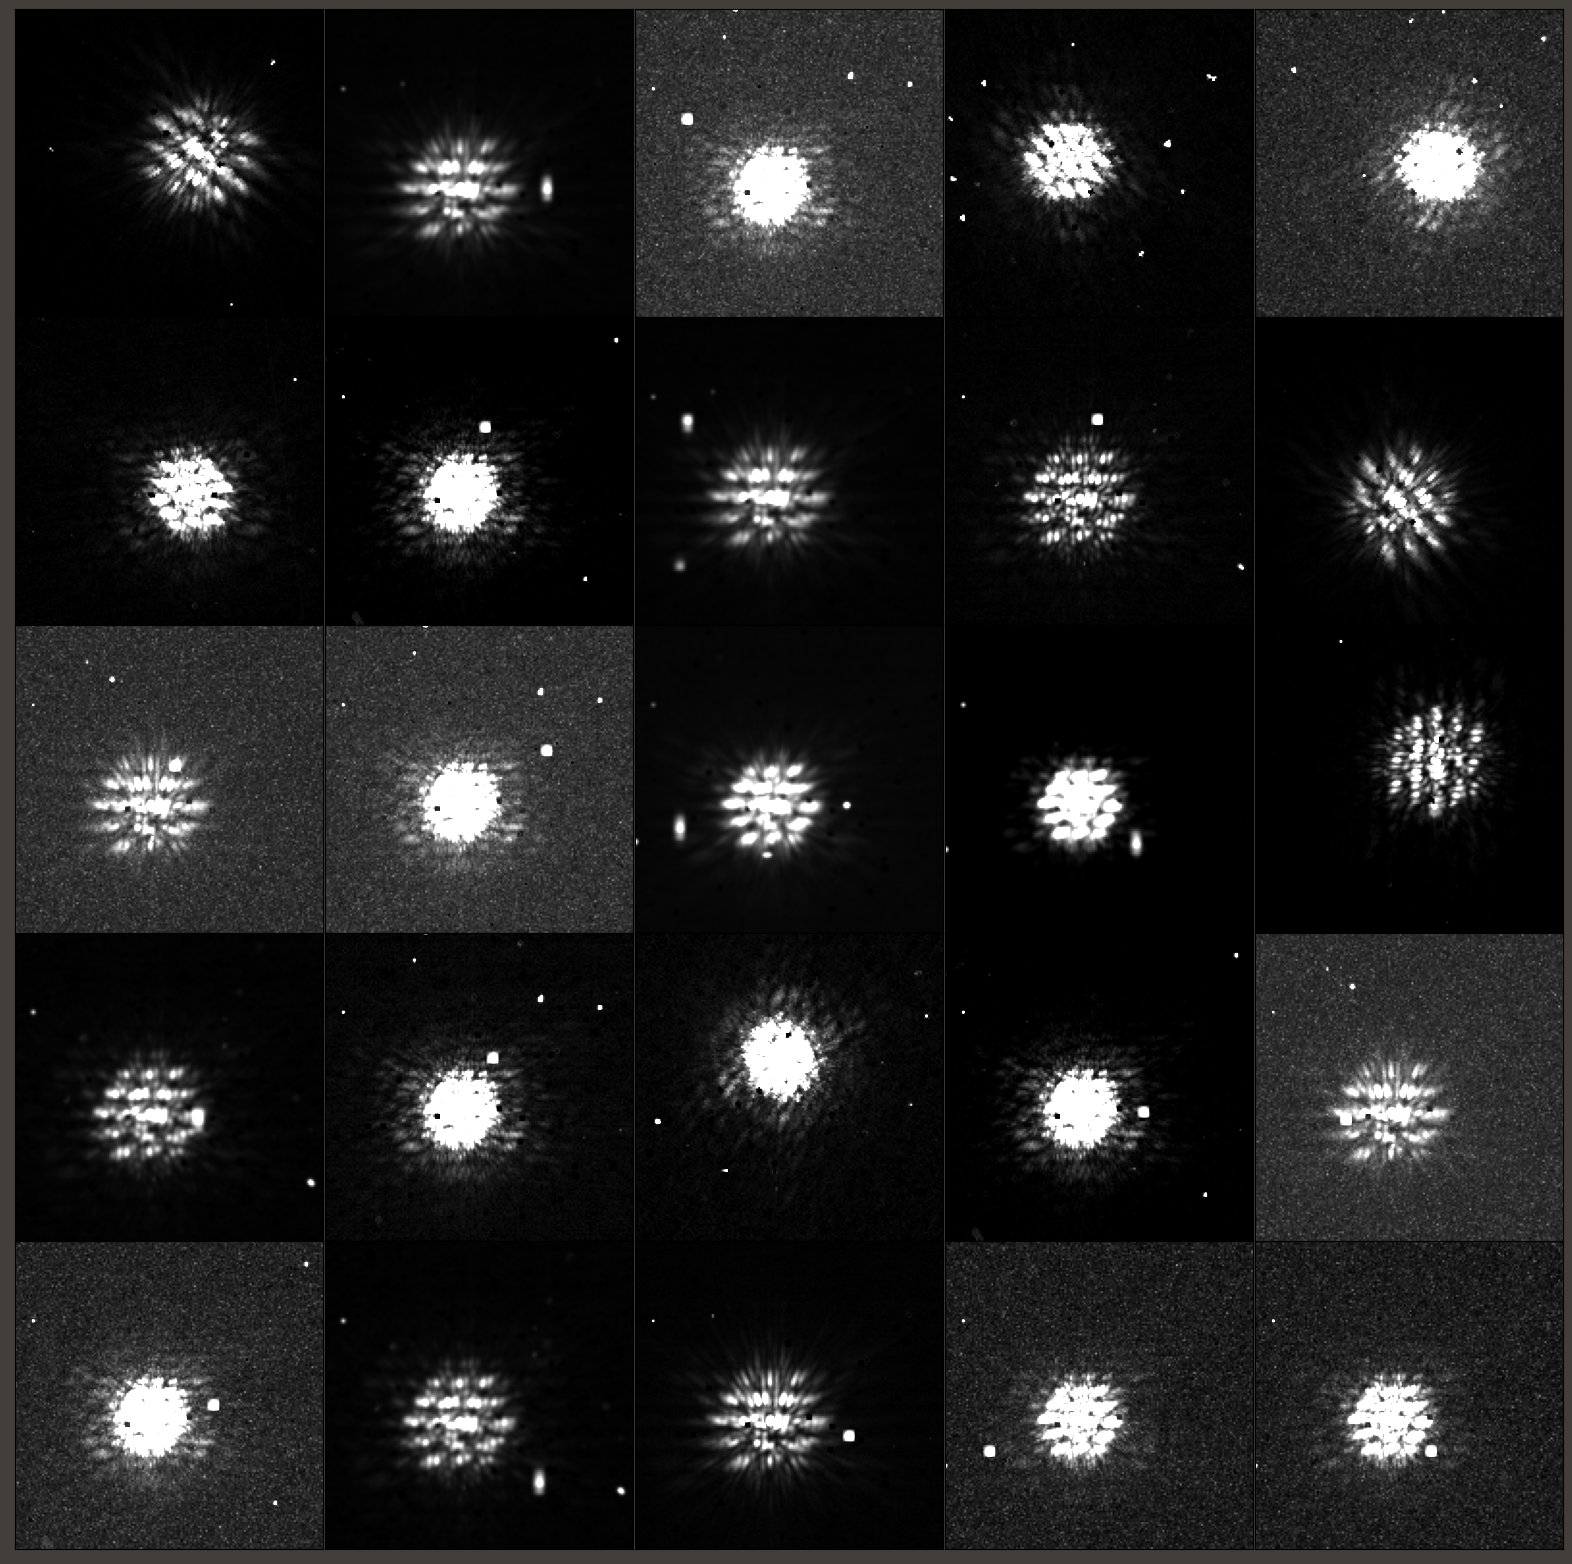

In [23]:
visualize_data(train_stack)

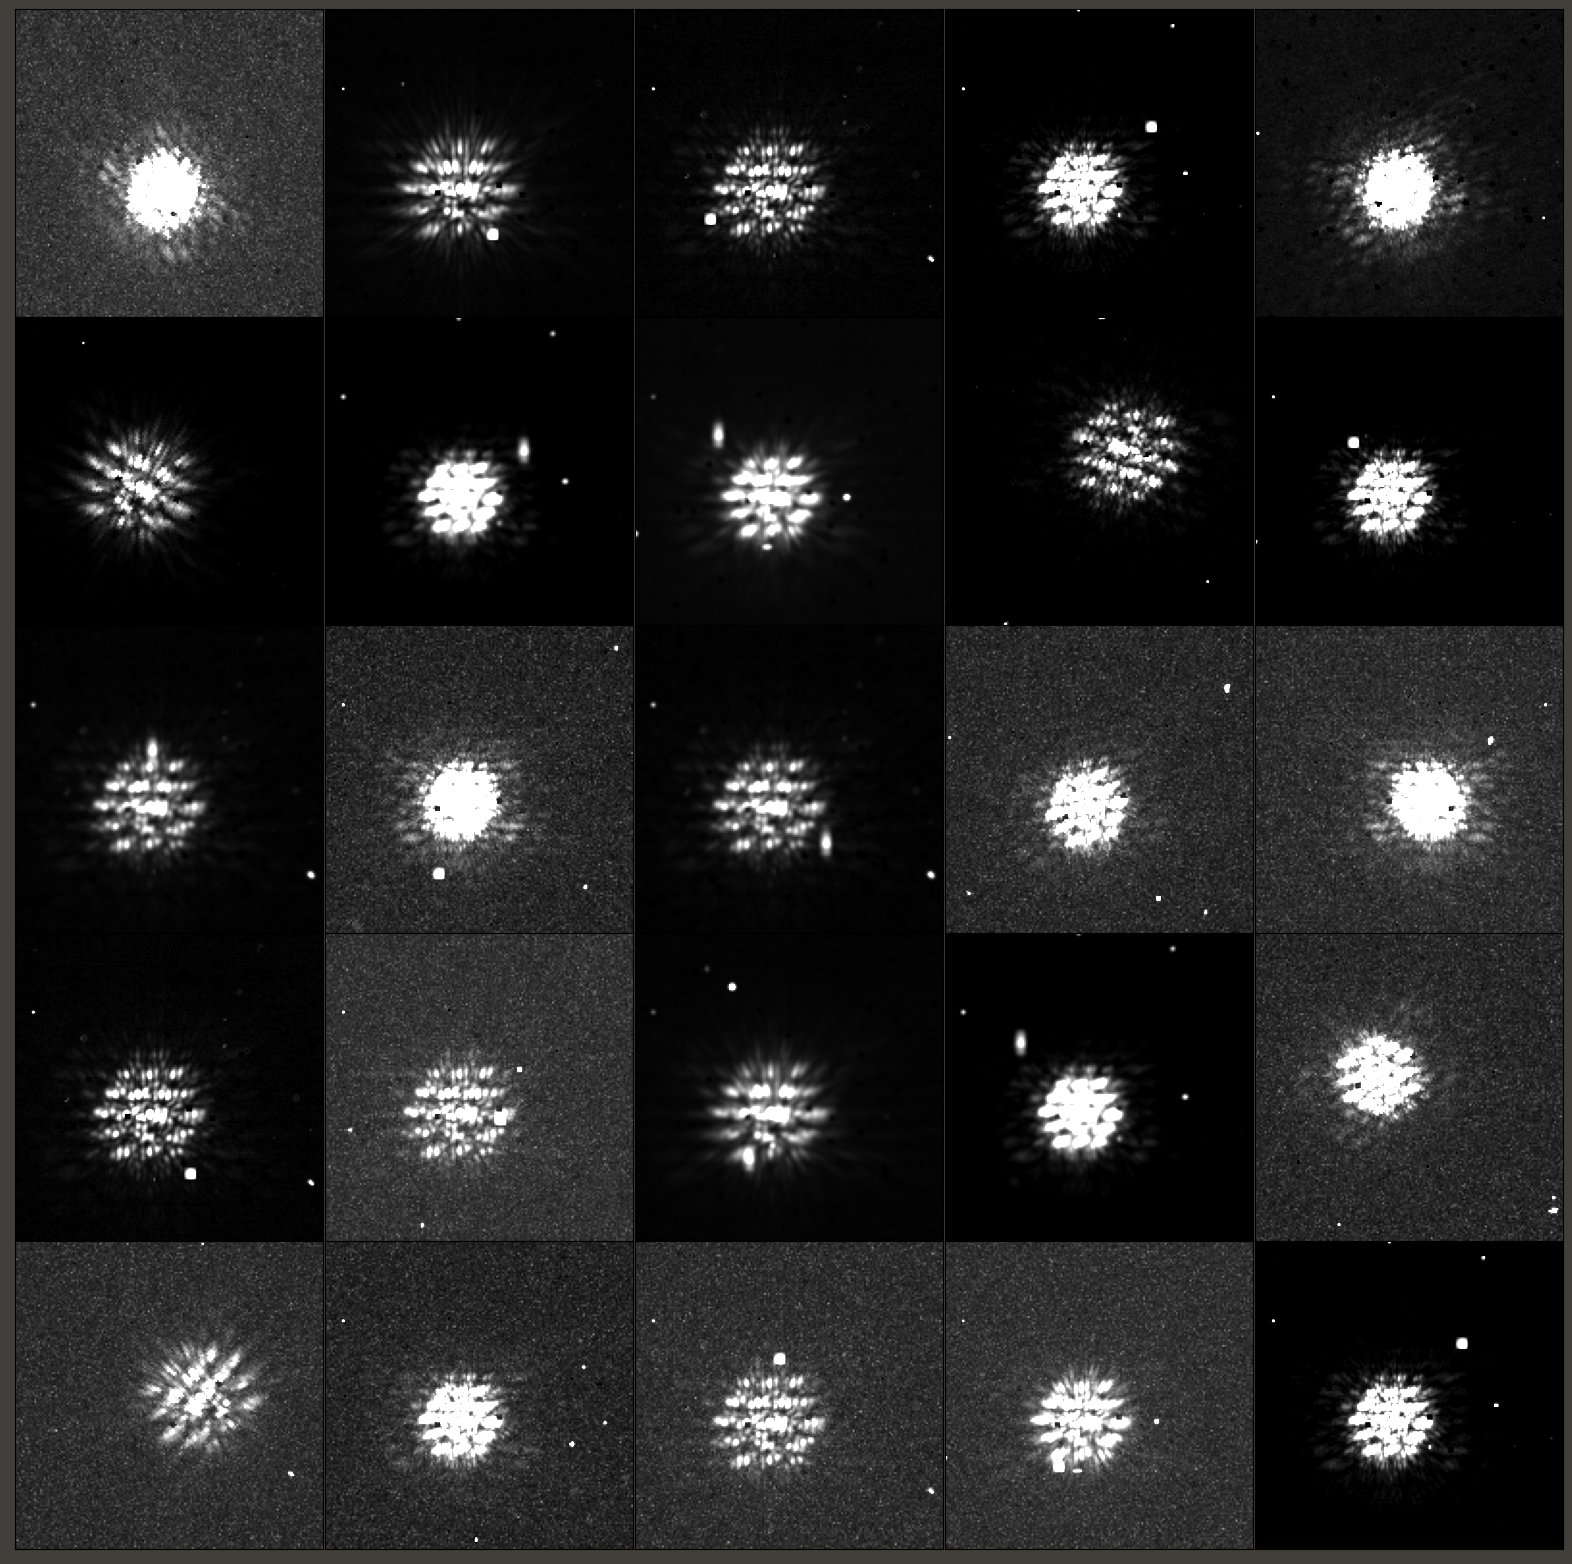

In [24]:
visualize_data(test_stack)

# Conv Calculater

In [29]:
def calculate_conv_dims(input_size,paddings:list,kernels:list,strides:list,maxpool:list):
    
    outputs = []
    outputs.append(input_size)
    for i in range(len(paddings)):
        
        output_size = (input_size + (2*paddings[i]) - (kernels[i] - 1) - 1)/strides[i] + 1
        if maxpool[i] != 0:
            print('0')
            output_size = (output_size  + (2*paddings[i]) - (maxpool[i]-1)-1)/2 +1
        
        outputs.append(int(output_size))
        input_size = output_size
        
    print(outputs)
    return outputs

In [105]:
kernels_forward = [3,3,3,3,3,3,3,3,3]
paddings_forward= [0,0,0,0,0,0,0,0,0]
strides_forward = [1,1,1,2,1,1,1,2,1]
maxpool = [0,0,0,0,0,0,0,0,0]

In [106]:
convdim_outputs = calculate_conv_dims(160,paddings_forward,kernels_forward,strides_forward,maxpool)

[160, 158, 156, 154, 76, 74, 72, 70, 34, 32]


In [78]:
def calculate_convtrans_dim(input_size,paddings:list,kernels:list,strides:list):
    outputs = []
    outputs.append(input_size)
    for i in range(len(paddings)):
        
        output_size = (input_size - 1) * strides[i]  -  2 * paddings[i] + kernels[i] - 1 + 1
        outputs.append(int(output_size))
        input_size = output_size
        
    print(outputs)
    return outputs

In [95]:
kernels_backward = [3,3,3,3,3,3,2]
paddings_backward= [0,0,0,0,0,0,0]
strides_backward = [1,1,1,2,1,2,1]

In [96]:
convtrans_outputs = calculate_convtrans_dim(32,paddings_backward,kernels_backward,strides_backward)

[32, 34, 36, 38, 77, 79, 159, 160]


In [97]:
class Exonet(nn.Module):
    
    def __init__(self,convdim_outputs:list,kernels:list,strides:list):
        
        super(Exonet,self).__init__()
        
        self.convdim = convdim_outputs
        self.kernels = kernels
        self.strides = strides
        self.C       = 8 
        
        self.exonet  = nn.Sequential(
                        
            nn.Conv2d(in_channels=1,out_channels=self.C,stride=strides[0],kernel_size=kernels[0]), #1
            nn.ReLU(),
            
            nn.Conv2d(in_channels=self.C,out_channels=self.C,stride=strides[1],kernel_size=kernels[1]), #2
            nn.ReLU(),
            
            nn.Conv2d(in_channels=self.C,out_channels=self.C,stride=strides[2],kernel_size=kernels[2]), #3
            nn.ReLU(),
            
            nn.Conv2d(in_channels=self.C,out_channels=self.C*2,stride=strides[3],kernel_size=kernels[3]), #4 
            nn.ReLU(),
            
            nn.Conv2d(in_channels=self.C*2,out_channels=self.C*2,stride=strides[4],kernel_size=kernels[4]), #5
            nn.ReLU(),
            
            nn.Conv2d(in_channels=self.C*2,out_channels=self.C*2,stride=strides[5],kernel_size=kernels[5]), #6
            nn.ReLU(),
            
            nn.Conv2d(in_channels=self.C*2,out_channels=self.C*2,stride=strides[6],kernel_size=kernels[6]), #7
            nn.ReLU(),
            
            nn.Conv2d(in_channels=self.C*2,out_channels=self.C*2,stride=strides[7],kernel_size=kernels[7]), #8
            nn.ReLU(),
            
            nn.Conv2d(in_channels=self.C*2,out_channels=self.C*2,stride=strides[8],kernel_size=kernels[8]), #9
            nn.ReLU(),
        
        ) 
        
        self.linear = nn.Sequential(
        
                nn.Linear((self.C*2)*convdim_outputs[-1]**2,4096),
                nn.ReLU(),
                nn.Linear(4096,1024),
                nn.ReLU(),
                nn.Linear(1024,2),
                nn.Softmax()
        )
        
        
    def forward(self,x):
        
        x = self.exonet(x)
        #print(x.shape)
        x = x.view(x.size(0),-1)
        
        x = self.linear(x)
        
        return x
        

In [ ]:
#device = torch.device("cuda:0, 3" if torch.cuda.is_available() else "cpu") ## specify the GPU id's, GPU id's start from 0.
#device = torch.device("cuda:0" if (torch.cuda.is_available() and 1 > 0) else "cpu")
#model = Exonet(convdim_outputs,kernels_forward,strides_forward)
#model  = torch.load('model1.pt')
#model  = nn.DataParallel(model,device_ids = [0, 1, 2, 3])
#model = model.to(device)
#model = model.to(f'cuda:{model.device_ids[0]}')

In [ ]:
#device = torch.device("cuda:0" if (torch.cuda.is_available() and 1 > 0) else "cpu")
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4) 
loss_fn = nn.CrossEntropyLoss()

In [ ]:
def train(model,dataloader,optimizer,device,loss_fn,EPOCH=30):
    
    with tqdm(total = len(dataloader) * EPOCH) as tt:
        
        model.train()
        
        for epoch in range(EPOCH):
            
            total_loss, batch_count = 0, 0
            
            for idx,(batch,label) in enumerate(dataloader):
                
                batch  = batch.float().to(f'cuda:{model.device_ids[0]}')
                label  = label.float().to(f'cuda:{model.device_ids[0]}')
                
                output = model(batch)
                
                loss = loss_fn(label,output)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                total_loss += loss.item()
                batch_count += 1
                tt.update()
                
            total_loss = total_loss / batch_count
            print(f'{total_loss}')

In [ ]:
#train(model=model,dataloader=train_dataloader,optimizer=optimizer,loss_fn=loss_fn,device=device,EPOCH=20)

In [ ]:
dataset = enumerate(test_dataloader)

In [ ]:
_,test_sample = next(dataset)

In [ ]:
results = model(test_sample[0].float().to(f'cuda:{model.device_ids[0]}'))

# Test the Model

In [ ]:
def test_(test_loader,model):
    logs = {}
    false_ = []
    
    with torch.no_grad():
        correct = 0
        incorrect = 0
        total = 0
        model.eval()
        arr = torch.randn((1,160,160)).to(f'cuda:{model.device_ids[0]}')
        
        for idx, (images,target) in enumerate(test_loader):
            
            images = images.float().to(f'cuda:{model.device_ids[0]}')
            target = target.float().to(f'cuda:{model.device_ids[0]}')
            
            outputs = model(images)
            predicted = torch.floor(outputs)
            
            where = torch.argwhere(torch.abs(predicted - target))
            
            for i in range(len(where)):
                
                arr = torch.vstack((arr,images[where[i][0]]))
            
            incorrect += torch.sum(torch.abs(predicted-target))
            
            correct += torch.abs(len(target) - incorrect)
            
            total += len(target) 
            
        print('Incorrect:',int(incorrect))
        print('Correct:',int(correct))
        print('Total:',total)
        print('Test Accuracy of the model: {} %'.format(100 * correct / total))
        #logs['accuracy'] = accuracy
        
        
    return arr[1:]
        

In [ ]:
false_classes = test_(test_dataloader,model)

In [ ]:
y_true = []
y_pred = []

for idx, (images,labels) in enumerate(test_dataloader):
    
    images = images.float().to(f'cuda:{model.device_ids[0]}')
    labels = labels.float().to(f'cuda:{model.device_ids[0]}')
    
    y_true.extend(labels.detach().cpu().numpy())

    outputs=model(images)

    predicted = torch.floor(outputs)
    y_pred.extend(predicted.detach().cpu().numpy())

In [ ]:
true_classes = []
predicted_classes = []

In [ ]:
for i in range(len(y_true)):
    
    if y_true[i][0] == 1.:
        true_classes.append('exo')
        
    if y_true[i][0] == 0.:
        true_classes.append('star')
        
    if y_pred[i][0] == 1.:
        predicted_classes.append('exo')
        
    if y_pred[i][0] == 0.:
        predicted_classes.append('star')


In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
cf_matrix = confusion_matrix(true_classes, predicted_classes, labels=["exo", "star"])

In [ ]:
class_names = ('exo','star')
dataframe = pd.DataFrame(cf_matrix, index=class_names, columns=class_names)

In [ ]:
dataframe

In [ ]:
plt.figure(figsize=(8, 6))
 
# Create heatmap
sns.heatmap(dataframe, annot=True, cbar=None,cmap="YlGnBu",fmt="d")
 
plt.title("Confusion Matrix"), plt.tight_layout()
 
plt.ylabel("True Class"), 
plt.xlabel("Predicted Class")
plt.show()

In [ ]:
precision = cf_matrix[0][0] / (cf_matrix[0][0] + cf_matrix[0][1])
recall = cf_matrix[0][0] / (cf_matrix[0][0] + cf_matrix[1][0])
f1 = (2*(precision)*recall)/precision+recall

In [ ]:
print("Precision:",precision)
print("Recall:",recall)
print("F1 score:",f1)

In [ ]:
visualize_data(false_classes.detach().cpu().numpy())